# Import package

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')
sns.set(style = 'whitegrid',context = 'notebook')

# generate classification report using predictions for categorical model
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn import (metrics,  linear_model, preprocessing)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, learning_curve, StratifiedKFold

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 175)

# Import data

In [2]:
df = pd.read_csv("diabetes.csv")
df.shape

(768, 9)

In [3]:
original_df = df.copy()

In [4]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [5]:
df.shape

(768, 9)

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


# Data Preprocessing

In [7]:
df = df.fillna(df.mean())
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
num_vars = [var for var in df.columns if df[var].dtypes != 'O']
numdf = df[num_vars].drop(['Outcome'],axis=1)

from sklearn.preprocessing import MinMaxScaler
numdf_norm = pd.DataFrame(MinMaxScaler().fit_transform(numdf))
numdf_norm.columns = numdf.columns

In [9]:
X = numdf_norm
print (X.shape)
y = df['Outcome']
print (y.shape)

(768, 8)
(768,)


## Spliting data into training and test set

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)
X_train.shape, X_test.shape

((614, 8), (154, 8))

# Train and perform cross validation

In [12]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()

kfold = KFold(n_splits = 10, random_state = 10)
scores = cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
scores

array([0.79032258, 0.62903226, 0.69354839, 0.74193548, 0.70491803,
       0.78688525, 0.83606557, 0.75409836, 0.72131148, 0.67213115])

In [13]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 73.30% (+/- 11.72%)


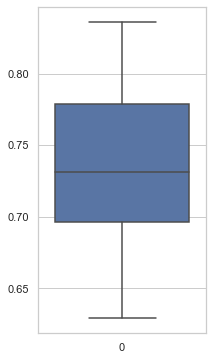

In [14]:
plt.figure(figsize=(3,6))
sns.boxplot(data=scores)
plt.show()

# Prediction

In [15]:
from lightgbm import LGBMClassifier

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
prob_train_pred = model.predict_proba(X_train)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
prob_test_pred = model.predict_proba(X_test)

# Model Evaluation

### Accuracy

In [16]:
accuracy_score(y_train, y_train_pred)

1.0

In [17]:
accuracy_score(y_test, y_test_pred)

0.7792207792207793

### Confusion matrix

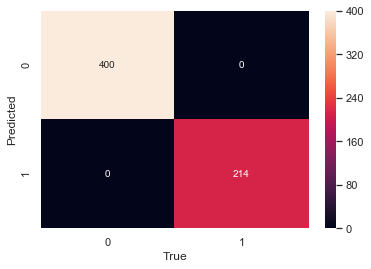

In [18]:
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

In [21]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       214

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



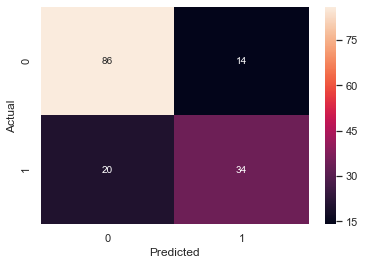

In [22]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

### Classification Report

In [23]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       100
           1       0.71      0.63      0.67        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.78      0.78      0.78       154



### ROC AUC Score

In [24]:
roc_auc_score(y_train, prob_train_pred[:,1])

1.0

In [25]:
roc_auc_score(y_test, prob_test_pred[:,1])

0.8218518518518518

### ROC Curve

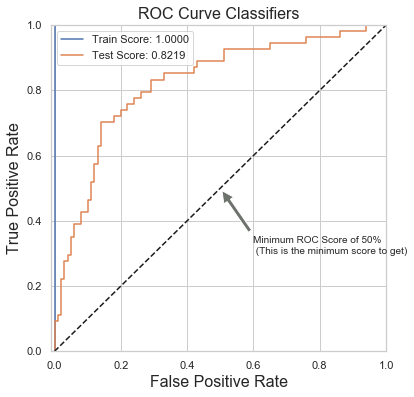

In [26]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()


### Precision-Recall curve

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.72')

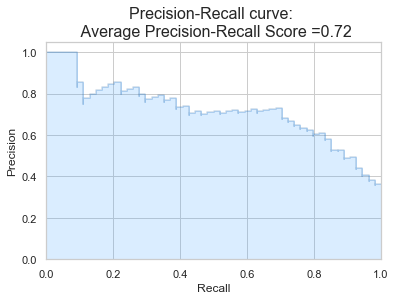

In [27]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_test_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

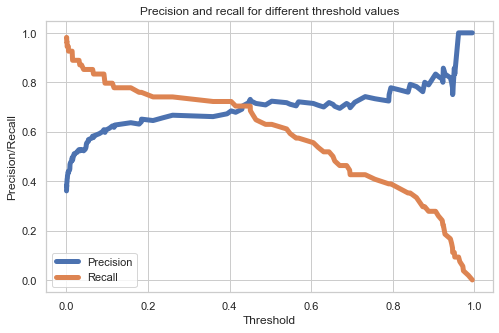

In [28]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =1.00')

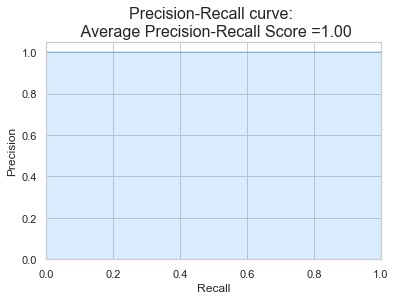

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_train_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

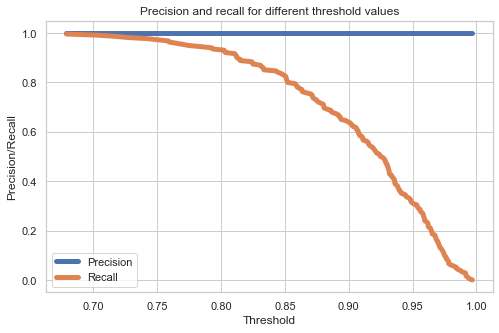

In [30]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### Summary

In [31]:
def ModelEvaluation(model,X_train,y_train,X_test,y_test,name):
    print('Model Evaluation of ' + name)

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, prob_train_pred[:,1]))
    cm_df = pd.DataFrame(confusion_matrix(y_train,y_train_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, prob_test_pred[:,1]))
    cm_df = pd.DataFrame(confusion_matrix(y_test,y_test_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_test, y_test_pred))
    

In [32]:
ModelEvaluation(model,X_train,y_train,X_test,y_test,'LGBMClassifier')

Model Evaluation of LGBMClassifier
-----------------------------------------------------------
Train set
Accuracy:  1.0
ROC AUC Score:  1.0
Confusion matrix
True         0    1
Predicted          
0          400    0
1            0  214
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       214

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614

-----------------------------------------------------------
Test set
Accuracy:  0.7792207792207793
ROC AUC Score:  0.8218518518518518
Confusion matrix
True        0   1
Predicted        
0          86  14
1          20  34
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       100
           1       0.71      0.63      0.67        54

    accuracy                           0.78      